## Import libraries

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv("/Users/emilywen/Documents/CMU MSBA/Machine Learning for Business Applications/Project/Telecommunications_Industry/Telco_customer_churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Pre-processing

#### Inspect column type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

#### Set Numeric Column Type

In [4]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

#### Drop columns

After discussion, we dropped location data and columns of similar nature and only retain Churn Value as the predictor.

In [5]:
df = df.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Reason'], axis=1)

#### Check Null Value

There are 11 null values in total charges. We decide to remove them directly.

In [6]:
df.isnull().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
CLTV                  0
dtype: int64

In [7]:
df = df.dropna()
df.isnull().sum()

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64

#### Feature Engineering

Instead of total charges or monthly charges, we decide to use charges per month as the only predictor for charges.

In [8]:
df['ChargesPerMonth'] = df['Total Charges'] / df['Tenure Months']

In [9]:
df = df.drop(['Total Charges', 'Monthly Charges'], axis=1)

#### One-hot encoding

In [10]:
df = pd.get_dummies(df, drop_first=True)
df

,Tenure Months,Churn Value,CLTV,ChargesPerMonth,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,2,1,3239,54.075000,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,2701,75.825000,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
2,8,1,5372,102.562500,0,0,0,1,1,0,...,0,1,0,1,0,0,1,0,1,0
3,28,1,5003,108.787500,0,0,1,1,1,0,...,0,1,0,1,0,0,1,0,1,0
4,49,1,5340,102.781633,1,0,0,1,1,0,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,72,0,5306,19.713889,0,0,0,0,1,0,...,1,0,1,0,0,1,1,0,0,0
7039,24,0,2140,82.937500,1,0,1,1,1,0,...,0,1,0,1,1,0,1,0,0,1
7040,72,0,5560,102.262500,0,0,1,1,1,0,...,0,1,0,1,1,0,1,1,0,0
7041,11,0,2793,31.495455,0,0,1,1,0,1,...,0,0,0,0,0,0,1,0,1,0


#### Data splitting

We used stratified strategy considering this is an imbalanced dataset.

In [11]:
y = df['Churn Value']
X = df.drop('Churn Value',axis=1)

# Stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

Double check that the stratified train set makes sense.

In [12]:
## check if y_train contains 2 classes

from collections import Counter

print(Counter(y_train))

Counter({0: 3614, 1: 1308})


#### Apply SMOTE on training data

Apply Smote on training data only helps prevent leaks to test data.

In [13]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Apply Tomek Links on training data

In [14]:
tomek_links = TomekLinks()
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train_smote, y_train_smote)

In [15]:
# Inspect the resampled data
df_smote = pd.concat([pd.DataFrame(X_train_resampled, columns=X.columns), pd.DataFrame(y_train_resampled, columns=['Churn Value'])], axis=1)
df_smote

,Tenure Months,CLTV,ChargesPerMonth,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,...,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Churn Value
0,11,2793,31.495455,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,66,4621,52.510606,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
2,72,4988,93.542361,1,1,1,0,1,0,1,...,0,0,0,0,1,1,0,0,0,0
3,19,3652,59.518421,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
4,65,5225,108.960769,0,1,1,0,1,0,1,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965,8,3577,84.061041,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
6966,1,2323,69.203913,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6967,12,2006,67.204578,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
6968,50,5464,55.361306,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Standardize the data

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Train and cross-validate

In [17]:
# Define l1 and l2 regression models
log_reg_ridge = LogisticRegression(penalty='l2', random_state=42, solver='liblinear')
log_reg_lasso = LogisticRegression(penalty='l1', random_state=42, solver='saga')

In [18]:
# Using pipelines for cross-validation later
ridge_pipeline = make_pipeline(StandardScaler(), log_reg_ridge)
lasso_pipeline = make_pipeline(StandardScaler(), log_reg_lasso)

In [19]:
# Define grid search range
# In here, I tried a few different ranges and discovered that the following ranges work best for AUC.

param_grid_ridge = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
# param_grid_lasso = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
# param_grid_ridge = {'logisticregression__C': [0.005, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
param_grid_lasso = {'logisticregression__C': [0.005, 0.025, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [20]:
# Grid search for Ridge (L2)
ridge_search = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='accuracy')
ridge_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [21]:
# Grid search for LASSO (L1)
lasso_search = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='accuracy')
lasso_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'logisticregression__C': [0.005, 0.025, 0.075, 0.1,
                                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                                   0.8, 0.9]},
             scoring='accuracy')

In [22]:
# Best parameters and scores
print("Best Ridge (L2) Params:", ridge_search.best_params_)
print("Best Ridge (L2) CV Score:", ridge_search.best_score_)

print("Best LASSO (L1) Params:", lasso_search.best_params_)
print("Best LASSO (L1) CV Score:", lasso_search.best_score_)

Best Ridge (L2) Params: {'logisticregression__C': 0.01}
Best Ridge (L2) CV Score: 0.8355810616929699
Best LASSO (L1) Params: {'logisticregression__C': 0.075}
Best LASSO (L1) CV Score: 0.837015781922525


The best parameter for Ridge is 0.01.
The best parameter for LASSO is 0.075.

#### Evaluate on the test set

Evaluating the best models on the test set, the accuracy is only 0.6853 and 0.6161 for Ridge and LASSO respectively.

In [23]:
# Evaluate on test set with best models
ridge_best_pipeline = ridge_search.best_estimator_
lasso_best_pipeline = lasso_search.best_estimator_

ridge_test_score = ridge_best_pipeline.score(X_test_scaled, y_test)
lasso_test_score = lasso_best_pipeline.score(X_test_scaled, y_test)

print("Ridge Test Score:", ridge_test_score)
print("LASSO Test Score:", lasso_test_score)

Ridge Test Score: 0.6853080568720379
LASSO Test Score: 0.6161137440758294


In [24]:
# Predict probabilities for the test set
ridge_probs = ridge_best_pipeline.predict_proba(X_test_scaled)[:, 1]
lasso_probs = lasso_best_pipeline.predict_proba(X_test_scaled)[:, 1]

In [25]:
# Predict classes for the test set
ridge_preds = ridge_best_pipeline.predict(X_test_scaled)
lasso_preds = lasso_best_pipeline.predict(X_test_scaled)

In [26]:
# Calculate metrics for Ridge (L2)
ridge_accuracy = accuracy_score(y_test, ridge_preds)
ridge_recall = recall_score(y_test, ridge_preds)
ridge_precision = precision_score(y_test, ridge_preds)
ridge_auc = roc_auc_score(y_test, ridge_probs)

In [27]:
# Calculate metrics for LASSO (L1)
lasso_accuracy = accuracy_score(y_test, lasso_preds)
lasso_recall = recall_score(y_test, lasso_preds)
lasso_precision = precision_score(y_test, lasso_preds)
lasso_auc = roc_auc_score(y_test, lasso_probs)

In [28]:
# Print metrics
print("Ridge (L2) - Accuracy:", ridge_accuracy)
print("Ridge (L2) - Recall:", ridge_recall)
print("Ridge (L2) - Precision:", ridge_precision)
print("Ridge (L2) - AUC:", ridge_auc)

print("LASSO (L1) - Accuracy:", lasso_accuracy)
print("LASSO (L1) - Recall:", lasso_recall)
print("LASSO (L1) - Precision:", lasso_precision)
print("LASSO (L1) - AUC:", lasso_auc)

Ridge (L2) - Accuracy: 0.6853080568720379
Ridge (L2) - Recall: 0.8627450980392157
Ridge (L2) - Precision: 0.4519140989729225
Ridge (L2) - AUC: 0.8132392930175181
LASSO (L1) - Accuracy: 0.6161137440758294
LASSO (L1) - Recall: 0.6951871657754011
LASSO (L1) - Precision: 0.37900874635568516
LASSO (L1) - AUC: 0.6881283882764914


- AUC: Ridge performs better than LASSO
- Accuracy: Ridge performs better than LASSO
- Recall: Ridge performs better than LASSO
- Precision: Ridge performs better than LASSO

In particular, Ridge has a very high recall, which is what we would like to see.

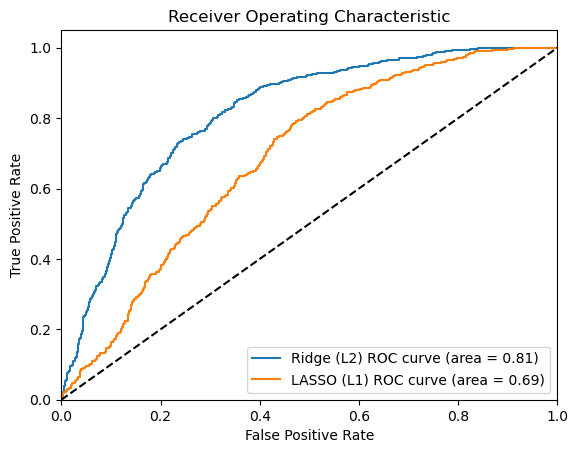

In [29]:
# Plot ROC curves
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, ridge_probs)
lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_probs)

plt.figure()
plt.plot(ridge_fpr, ridge_tpr, label='Ridge (L2) ROC curve (area = %0.2f)' % ridge_auc)
plt.plot(lasso_fpr, lasso_tpr, label='LASSO (L1) ROC curve (area = %0.2f)' % lasso_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Calibration Curve

In [30]:
# Compute calibration curve
ridge_frac_pos, ridge_mean_pred = calibration_curve(y_test, ridge_probs, n_bins=10)
lasso_frac_pos, lasso_mean_pred = calibration_curve(y_test, lasso_probs, n_bins=10)


Logistics regression is supposed to be calibrated natively, but this chart shows otherwise... There are a few reasons for it according to ChatGPT:

1. Imbalanced Data: If the dataset is imbalanced, it can affect the calibration. Ensure proper handling of class imbalance.
2. Regularization: Strong regularization (L1 or L2) can impact the calibration, especially if not tuned properly.
3. Feature Scaling: Ensure that all preprocessing steps, including scaling, are correctly applied.
4. Model Complexity: Logistic regression may not capture complex patterns if the data is non-linear or has complex interactions.
5. Data Quality: Check for noise or outliers in the data that could affect predictions.

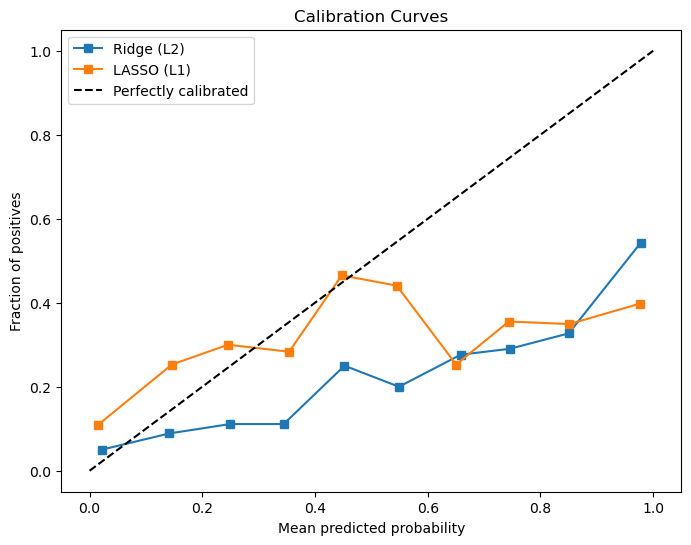

In [31]:
# Plot calibration curves
plt.figure(figsize=(8, 6))
plt.plot(ridge_mean_pred, ridge_frac_pos, "s-", label='Ridge (L2)')
plt.plot(lasso_mean_pred, lasso_frac_pos, "s-", label='LASSO (L1)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend(loc="upper left")
plt.show()

### Understand feature importance

Axes(0.125,0.11;0.775x0.77)


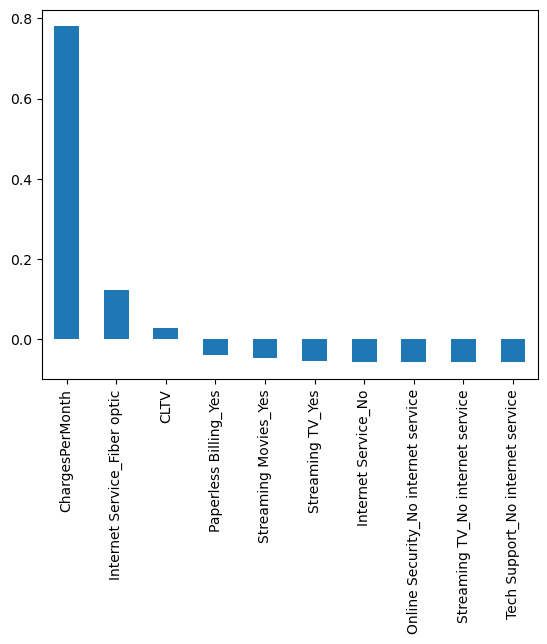

In [32]:
# Get the best LASSO and Ridge models from the grid search
best_ridge_model = ridge_search.best_estimator_.named_steps['logisticregression']
best_lasso_model = lasso_search.best_estimator_.named_steps['logisticregression']

# Get the coefficients
ridge_coefficients = best_ridge_model.coef_
lasso_coefficients = best_lasso_model.coef_

# Get weights of the first 10 variables for Ridge
weights_ridge = pd.Series(best_ridge_model.coef_[0],
                 index=X.columns.values)
print (weights_ridge.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


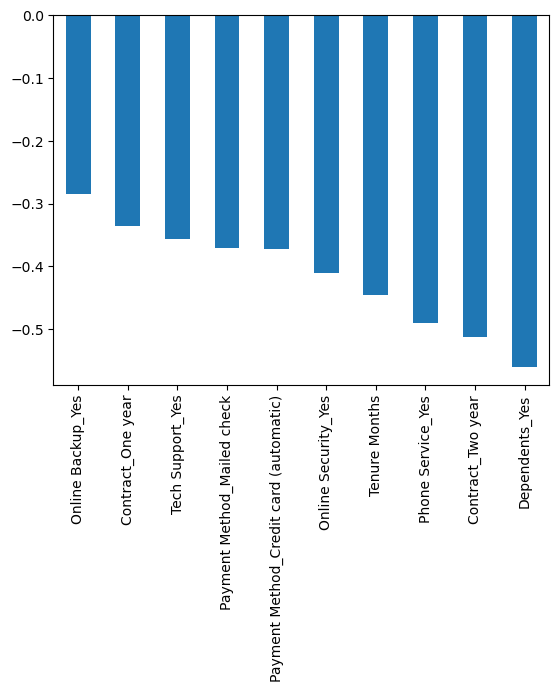

In [33]:
print(weights_ridge.sort_values(ascending = False)[-10:].plot(kind='bar'))


Axes(0.125,0.11;0.775x0.77)


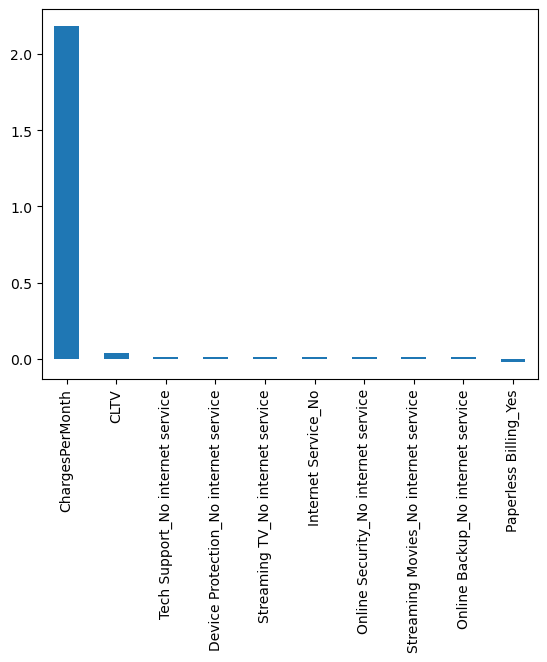

In [34]:
# Get weights of the first 10 variables for LASSO
weights_lasso = pd.Series(best_lasso_model.coef_[0],
                 index=X.columns.values)
print (weights_lasso.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


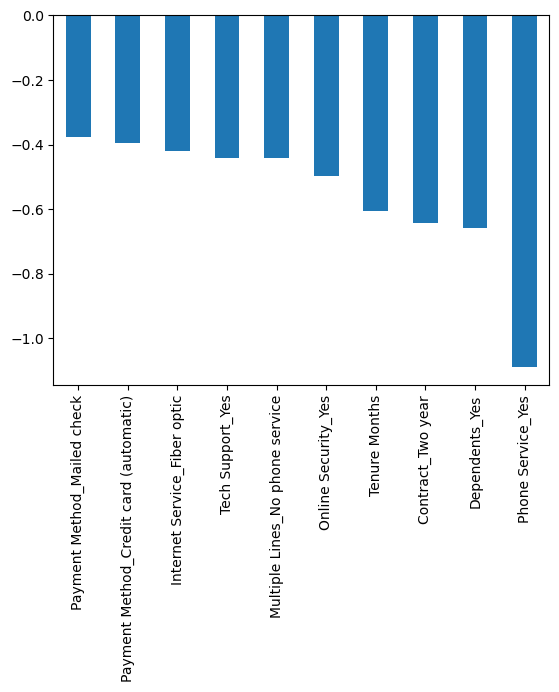

In [35]:
print(weights_lasso.sort_values(ascending = False)[-10:].plot(kind='bar'))


#### Attempt to Calibrate... unsuccessfully

In [36]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_ridge = CalibratedClassifierCV(ridge_best_pipeline, method='sigmoid', cv='prefit')
calibrated_ridge.fit(X_train_resampled, y_train_resampled)

calibrated_lasso = CalibratedClassifierCV(lasso_best_pipeline, method='sigmoid', cv='prefit')
calibrated_lasso.fit(X_train_resampled, y_train_resampled)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('logisticregression',
                                                  LogisticRegression(C=0.075,
                                                                     penalty='l1',
                                                                     random_state=42,
                                                                     solver='saga'))]))

In [37]:
# Predict probabilities for AUC and ROC
ridge_probs_calibrated = calibrated_ridge.predict_proba(X_test_scaled)[:, 1]
lasso_probs_calibrated = calibrated_lasso.predict_proba(X_test_scaled)[:, 1]

# Predict classes for the test set
ridge_preds_calibrated = calibrated_ridge.predict(X_test_scaled)
lasso_preds_calibrated = calibrated_lasso.predict(X_test_scaled)

In [38]:
# Calculate metrics for calibrated Ridge (L2)
ridge_accuracy_calibrated = accuracy_score(y_test, ridge_preds_calibrated)
ridge_precision_calibrated = precision_score(y_test, ridge_preds_calibrated)
ridge_recall_calibrated = recall_score(y_test, ridge_preds_calibrated)
ridge_auc_calibrated = roc_auc_score(y_test, ridge_probs_calibrated)

# Calculate metrics for calibrated LASSO (L1)
lasso_accuracy_calibrated = accuracy_score(y_test, lasso_preds_calibrated)
lasso_precision_calibrated = precision_score(y_test, lasso_preds_calibrated)
lasso_recall_calibrated = recall_score(y_test, lasso_preds_calibrated)
lasso_auc_calibrated = roc_auc_score(y_test, lasso_probs_calibrated)

In [39]:
# Print metrics
print("Calibrated Ridge (L2) - Accuracy:", ridge_accuracy_calibrated)
print("Calibrated Ridge (L2) - Precision:", ridge_precision_calibrated)
print("Calibrated Ridge (L2) - Recall:", ridge_recall_calibrated)
print("Calibrated Ridge (L2) - AUC:", ridge_auc_calibrated)

print("Calibrated LASSO (L1) - Accuracy:", lasso_accuracy_calibrated)
print("Calibrated LASSO (L1) - Precision:", lasso_precision_calibrated)
print("Calibrated LASSO (L1) - Recall:", lasso_recall_calibrated)
print("Calibrated LASSO (L1) - AUC:", lasso_auc_calibrated)

Calibrated Ridge (L2) - Accuracy: 0.6890995260663507
Calibrated Ridge (L2) - Precision: 0.45514636449480644
Calibrated Ridge (L2) - Recall: 0.8591800356506238
Calibrated Ridge (L2) - AUC: 0.8132392930175181
Calibrated LASSO (L1) - Accuracy: 0.6161137440758294
Calibrated LASSO (L1) - Precision: 0.37900874635568516
Calibrated LASSO (L1) - Recall: 0.6951871657754011
Calibrated LASSO (L1) - AUC: 0.6881283882764914


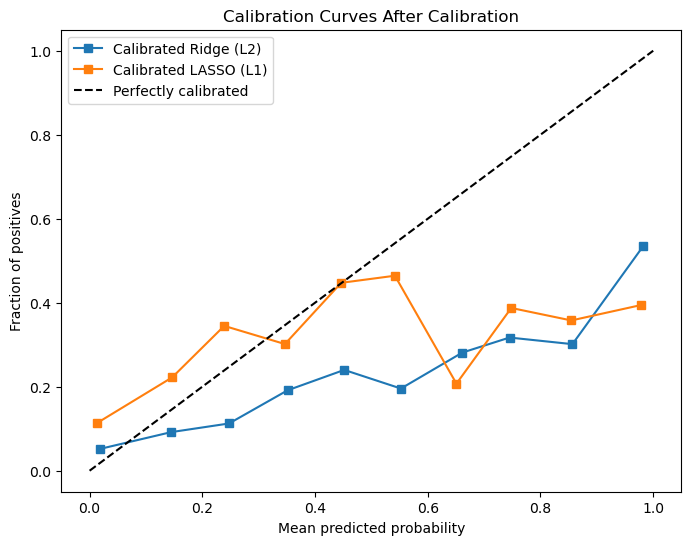

In [40]:
# Compute and plot calibration curves
ridge_frac_pos_calibrated, ridge_mean_pred_calibrated = calibration_curve(y_test, ridge_probs_calibrated, n_bins=10)
lasso_frac_pos_calibrated, lasso_mean_pred_calibrated = calibration_curve(y_test, lasso_probs_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(ridge_mean_pred_calibrated, ridge_frac_pos_calibrated, "s-", label='Calibrated Ridge (L2)')
plt.plot(lasso_mean_pred_calibrated, lasso_frac_pos_calibrated, "s-", label='Calibrated LASSO (L1)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves After Calibration')
plt.legend(loc="upper left")
plt.show()